# Multi-Label Classification

## 1. Imports

In [148]:
import ast
import pickle
import random
import re
import string
import unicodedata
from collections import Counter
from pathlib import Path
from typing import Any, Union, Optional, Callable

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk import WordNetLemmatizer, word_tokenize
from nltk.corpus import stopwords, wordnet
from numpy import asarray
from numpy.typing import ArrayLike
from sentence_transformers import SentenceTransformer
from sklearn import preprocessing
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss, accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from tqdm.contrib.itertools import product
from tqdm.notebook import tqdm
from wordcloud import WordCloud

import MLC

In [155]:
def replace_text_components(
        text: str,
        replace_emails: bool = True,
        replace_urls: bool = True,
        replace_mentions: bool = True,
        replace_hashtags: bool = True,
        replace_phone_numbers: bool = True,
        custom_replacements: Optional[dict[str, str]] = None,
) -> str:
    """
    Replace specific text components (e.g., emails, URLs, mentions, hashtags) with placeholders.

    Parameters
    ----------
    text : str
        Input text to process.
    replace_emails : bool
        Whether to replace email addresses. Default is True.
    replace_urls : bool
        Whether to replace URLs. Default is True.
    replace_mentions : bool
        Whether to replace mentioned users. Default is True.
    replace_hashtags : bool
        Whether to replace hashtags. Default is True.
    replace_phone_numbers : bool
        Whether to replace phone numbers. Default is True.
    custom_replacements : dict
        Custom replacement rules as a dictionary. Default is None.

    Returns
    -------
    str : str
        Text with specified components replaced.
    """
    # Replace email addresses
    if replace_emails:
        text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "", text)

    # Replace URLs
    if replace_urls:
        text = re.sub(r"https?://\S+|www\.\S+", "", text)

    # Replace mentioned users
    if replace_mentions:
        text = re.sub(r"@\w+", "", text)

    # Replace hashtags
    if replace_hashtags:
        text = re.sub(r"#\w+", "", text)  # Remove hashtags entirely

    # Replace phone numbers
    if replace_phone_numbers:
        text = re.sub(
            r"\b(?:\+\d{1,2}\s?)?(?:\(\d{3}\)|\d{3})[\s.-]?\d{3}[\s.-]?\d{4}\b",
            "",
            text,
        )

    # Apply custom replacements if provided
    if custom_replacements is not None:
        for pattern, replacement in custom_replacements.items():
            text = re.sub(pattern, replacement, text)

    return text


def clean_text(
        text: str,
        remove_punctuation: bool = True,
        remove_emojis: bool = True,
        normalize_whitespace: bool = True,
        lowercase: bool = True,
) -> str:
    """
    Clean and preprocess text data for machine learning tasks.

    Parameters
    ----------
    text : str
        Input text to be cleaned.
    remove_punctuation : bool
        Whether to remove punctuation. Default is True.
    remove_emojis : bool
        Whether to remove emojis and emoticons. Default is True.
    normalize_whitespace : bool
        Whether to normalize whitespace. Default is True.
    lowercase : bool
        Whether to convert text to lowercase. Default is True.

    Returns
    -------
    str : str
        Cleaned and preprocessed text.
    """
    # Convert text to lowercase if specified
    if lowercase:
        text = text.lower()

    # Remove punctuation if specified
    if remove_punctuation:
        text = re.sub(r"[^\w\s]", "", text)

    # Normalize whitespace if specified
    if normalize_whitespace:
        text = re.sub(r"\s+", " ", text).strip()

    # Remove emojis and emoticons if specified
    if remove_emojis:
        # Remove emojis and emoticons using Unicode ranges
        text = re.sub(r"[\U00010000-\U0010ffff]", "", text)
        # Remove additional emoticons and symbols
        text = re.sub(r"[\u2600-\u26FF\u2700-\u27BF]", "", text)

    # Normalize Unicode characters (e.g., convert accented characters to their base form)
    text = (
        unicodedata.normalize("NFKD", text)
        .encode("ascii", "ignore")
        .decode("utf-8", "ignore")
    )

    return text


def get_wordnet_pos(treebank_tag):
    """
    Map Treebank POS tags to WordNet POS tags for lemmatization.

    Args:
        treebank_tag (str): Treebank POS tag.

    Returns:
        str: Corresponding WordNet POS tag.
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if no match


def lemmatize_text(text, lemmatizer=WordNetLemmatizer()):
    """
    Lemmatize text using WordNetLemmatizer with POS tagging for better accuracy.

    Parameters
    ----------
    text : str
        Input text to be lemmatized.
    lemmatizer : WordNetLemmatizer
        Lemmatizer instance.

    Returns
    -------
        str: Lemmatized text.
    """
    # Tokenize the text
    tokens = word_tokenize(text)

    # Get POS tags for each token
    pos_tags = nltk.pos_tag(tokens)

    # Lemmatize each token with its corresponding POS tag
    lemmatized_tokens = []
    for token, tag in pos_tags:
        wordnet_pos = get_wordnet_pos(tag)  # Convert Treebank tag to WordNet POS
        lemmatized_token = lemmatizer.lemmatize(token, pos=wordnet_pos)
        lemmatized_tokens.append(lemmatized_token)

    # Join the lemmatized tokens into a single string
    return " ".join(lemmatized_tokens)


def remove_stopwords(text, language='english', custom_stopwords=None, lowercase=True):
    """
    Remove stopwords from the input text.

    Args:
        text (str): Input text to process.
        language (str): Language of the stopwords. Default is 'english'.
        custom_stopwords (set): Custom set of stopwords to use. Default is None.
        lowercase (bool): Whether to convert text to lowercase before processing. Default is True.

    Returns:
        str: Text with stopwords removed.
    """
    # Convert text to lowercase if specified
    if lowercase:
        text = text.lower()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Load stopwords
    if custom_stopwords is not None:
        stop_words = set(custom_stopwords)
    else:
        stop_words = set(stopwords.words(language))

    # Remove stopwords
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # Join the filtered tokens into a single string
    return ' '.join(filtered_tokens)


def map_targets(watson_list, fix_targets):
    targets = set(fix_targets.keys()) & set(watson_list)
    mapped_targets = {fix_targets[category] for category in targets}
    return list(mapped_targets) if mapped_targets else ["other"]


def assess(Y: ArrayLike, Y_pred: ArrayLike) -> dict[str, float]:
    """
    Evaluate the model on the given data.

    Parameters
    ----------
    Y : ArrayLike of shape (n_samples, n_labels)
        The input features.
    Y_pred : ArrayLike of shape (n_samples, n_labels)
        The true binary label matrix.

    Returns
    -------
    metrics : dict[str, float]
        Dictionary containing accuracy, micro F1 score, and hamming loss.
    """
    accuracy = accuracy_score(Y, Y_pred)

    auc_score_micro = roc_auc_score(Y, Y_pred, average="micro")
    auc_score_macro = roc_auc_score(Y, Y_pred, average="macro")
    auc_score_weighted = roc_auc_score(Y, Y_pred, average="weighted")
    auc_score_samples = roc_auc_score(Y, Y_pred, average="samples")
    auc_per_label = roc_auc_score(Y, Y_pred, average=None)

    report = classification_report(Y, Y_pred, output_dict=True, zero_division=0.0)
    report["micro avg"]["auc"] = auc_score_micro
    report["macro avg"]["auc"] = auc_score_macro
    report["weighted avg"]["auc"] = auc_score_weighted
    report["samples avg"]["auc"] = auc_score_samples

    n_classes = Y.shape[1]
    class_names = [f"{i}" for i in range(n_classes)]
    for i, target in enumerate(class_names):
        if target in report:
            report[target]["auc"] = auc_per_label[i]
        else:
            # In case labels are not printed per class, you can store them separately
            report[target] = {"auc": auc_per_label[i]}

    hamming = hamming_loss(Y, Y_pred)
    return {
        "accuracy": accuracy,
        "hamming_loss": hamming,
        "report": report
    }

In [152]:
class ModuleSystem(BaseEstimator, ClassifierMixin):
    def __init__(self, models, classes):
        self.models = models
        self.mlb = preprocessing.MultiLabelBinarizer(classes=classes)

    def predict(self, X_test: ArrayLike) -> ArrayLike:
        """
        Predict labels for each component using the chosen model in the dictionary.

        Parameters
        ----------
        X_test : ArrayLike
            Test data.

        Returns
        -------
        Y_pred : ArrayLike
            Predicted labels for each component.
        """
        n_samples = X_test.shape[0]
        n_components = len(self.models)
        Y_pred = np.zeros((n_samples, n_components))

        for idx, model_info in self.models.items():
            model = model_info['model']
            Y_pred[:, int(idx)] = (model.predict(X_test))[:, int(idx)]

        return Y_pred

## 2. Configurations & Constants

In [2]:
FIX_TARGETS = {
    "computer security": "computer security",
    "operating systems": "operating systems",
    "software": "software",
    "programming languages": "software",
    "hardware": "hardware",
    "electronic components": "hardware",
    "networking": "networking",
    "internet technology": "networking",
}
OVERWRITE = False
RETRAIN = False
RANDOM_STATE = 42
MODEL_LEVEL = "general"
TEST_SIZE = 2e-1

np.random.seed(seed=RANDOM_STATE)
random.seed(a=RANDOM_STATE)

### Directory Paths

In [6]:
COLAB_DIR = Path("/content/drive/MyDrive")
KAGGLE_DIR = Path("/kaggle/input")
LOCAL_DIR = Path("../")

try:
    import google.colab

    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import kaggle_secrets

    IN_KAGGLE = True
except ImportError:
    IN_KAGGLE = False

if IN_COLAB:
    DATA_DIR = COLAB_DIR / "data"
    MODELS_DIR = COLAB_DIR / "models"
elif IN_KAGGLE:
    DATA_DIR = KAGGLE_DIR
    MODELS_DIR = KAGGLE_DIR
else:
    DATA_DIR = LOCAL_DIR / "data"
    MODELS_DIR = LOCAL_DIR / "models"

In [7]:
TWEETS_CSV = DATA_DIR / "tweets-dataset/categories_train.csv"
GENERAL_PKL = MODELS_DIR / "general.pkl"

## 3. Data Loading & Preprocessing

Load the dataset, inspect its structure, and preprocess it for machine learning models.
For the goal of the project, the categories of interest are:
1. computer security/network security
2. computer security/antivirus and malware
3. operating systems/mac os
4. operating systems/windows
5. operating systems/unix
6. operating systems/linux
7. software
8. programming languages, included in software
9. software/databases
10. hardware
11. electronic components, included in hardware
12. hardware/computer/servers
13. hardware/computer/portable computer
14. hardware/computer/desktop computer
15. hardware/computer components
16. hardware/computer networking/router
17. hardware/computer networking/wireless technology
18. networking
19. internet technology, included in networking

In [15]:
with open(TWEETS_CSV, "rb") as f:
    tweets = pd.read_csv(f)

tweets = tweets.assign(
    tweet=lambda df: df["tweet"].apply(func=ast.literal_eval),
    watson=lambda df: df["watson"].apply(func=ast.literal_eval),
    urls=lambda df: df["urls"].apply(func=ast.literal_eval),
    watson_list=lambda df: df["watson_list"].apply(func=ast.literal_eval),
    target=lambda df: df["target"].apply(func=ast.literal_eval),
)

tweets.head()

,Unnamed: 0,_id,date,id,relevant,text,tweet,type,watson,annotation,urls,destination_url,valid_certificate,watson_list,target
0,4073,b'5b921eb9bb325e70071880f4',2018-09-07 06:46:17+00:00,1037955195102089216,True,New Fallout Exploit Kit Drops GandCrab Ransomw...,{'created_at': 'Fri Sep 07 06:46:17 +0000 2018...,ransomware,{'technology and computing': {'computer securi...,threat,[https://www.bleepingcomputer.com/news/securit...,https://www.bleepingcomputer.com/news/security...,True,"[technology and computing, computer security, ...","[computer security, antivirus and malware]"
1,10604,b'5b97837bbb325e7a2e19a410',2018-09-11 08:57:30+00:00,1039437770144538625,True,threatmeter: #0daytoday #Bayanno Hospital Mana...,{'created_at': 'Tue Sep 11 08:57:30 +0000 2018...,vulnerability,{'technology and computing': {'programming lan...,threat,[https://twitter.com/i/web/status/103943777014...,https://twitter.com/i/web/status/1039437770144...,True,"[technology and computing, programming languag...",[software]
2,9207,b'5b969b5cbb325e7a2e19986a',2018-09-10 16:27:07+00:00,1039188531313180673,True,Advantech WebAccess webvrpcs.exe Path Traversa...,{'created_at': 'Mon Sep 10 16:27:07 +0000 2018...,general,{'technology and computing': {'computer securi...,threat,[https://goo.gl/fb/cezMA7],https://www.tenable.com/plugins/nessus/117360,True,"[technology and computing, computer security, ...","[computer security, network security]"
3,2554,b'5b913992bb325e7007187154',2018-09-06 14:28:34+00:00,1037709143086387200,True,@kategraham23 Vulnerability is now by far one ...,{'created_at': 'Thu Sep 06 14:28:34 +0000 2018...,vulnerability,{'technology and computing': {'computer securi...,NaN,[],NaN,NaN,"[technology and computing, computer security, ...","[computer security, network security, antiviru..."
4,615,b'5b8dd8b2bb325e2996c668ee',2018-09-04 00:58:26+00:00,1036780490592870401,True,"New Hakai IoT botnet takes aim at D-Link, Huaw...",{'created_at': 'Tue Sep 04 00:58:26 +0000 2018...,botnet,{'technology and computing': {'hardware': {'co...,threat,[https://www.zdnet.com/article/new-hakai-iot-b...,https://www.zdnet.com/article/new-hakai-iot-bo...,True,"[technology and computing, hardware, computer ...","[hardware, software, computer, router, compute..."


In [17]:
tweets = tweets.assign(
    target=lambda df: df["target"].apply(func=map_targets, args=(FIX_TARGETS,))
)
tweets['text'] = [replace_text_components(t) for t in tweets['text']]
tweets['clean_text'] = [clean_text(t) for t in tweets['text']]
tweets['clean_text'] = [lemmatize_text(t) for t in tweets['clean_text']]
tweets['clean_text'] = [remove_stopwords(t) for t in tweets['clean_text']]

print(f"Threat Tweets: {len(tweets)}")
tweets.head()

Threat Tweets: 8700


,Unnamed: 0,_id,date,id,relevant,text,tweet,type,watson,annotation,urls,destination_url,valid_certificate,watson_list,target,clean_text
0,4073,b'5b921eb9bb325e70071880f4',2018-09-07 06:46:17+00:00,1037955195102089216,True,New Fallout Exploit Kit Drops GandCrab Ransomw...,{'created_at': 'Fri Sep 07 06:46:17 +0000 2018...,ransomware,{'technology and computing': {'computer securi...,threat,[https://www.bleepingcomputer.com/news/securit...,https://www.bleepingcomputer.com/news/security...,True,"[technology and computing, computer security, ...",[computer security],new fallout exploit kit drop gandcrab ransomwa...
1,10604,b'5b97837bbb325e7a2e19a410',2018-09-11 08:57:30+00:00,1039437770144538625,True,threatmeter: Hospital Management System 4.0 ...,{'created_at': 'Tue Sep 11 08:57:30 +0000 2018...,vulnerability,{'technology and computing': {'programming lan...,threat,[https://twitter.com/i/web/status/103943777014...,https://twitter.com/i/web/status/1039437770144...,True,"[technology and computing, programming languag...",[software],threatmeter hospital management system 40 cros...
2,9207,b'5b969b5cbb325e7a2e19986a',2018-09-10 16:27:07+00:00,1039188531313180673,True,Advantech WebAccess webvrpcs.exe Path Traversa...,{'created_at': 'Mon Sep 10 16:27:07 +0000 2018...,general,{'technology and computing': {'computer securi...,threat,[https://goo.gl/fb/cezMA7],https://www.tenable.com/plugins/nessus/117360,True,"[technology and computing, computer security, ...",[computer security],advantech webaccess webvrpcsexe path traversal...
3,2554,b'5b913992bb325e7007187154',2018-09-06 14:28:34+00:00,1037709143086387200,True,Vulnerability is now by far one of the traits...,{'created_at': 'Thu Sep 06 14:28:34 +0000 2018...,vulnerability,{'technology and computing': {'computer securi...,NaN,[],NaN,NaN,"[technology and computing, computer security, ...",[computer security],vulnerability far one trait admire people
4,615,b'5b8dd8b2bb325e2996c668ee',2018-09-04 00:58:26+00:00,1036780490592870401,True,"New Hakai IoT botnet takes aim at D-Link, Huaw...",{'created_at': 'Tue Sep 04 00:58:26 +0000 2018...,botnet,{'technology and computing': {'hardware': {'co...,threat,[https://www.zdnet.com/article/new-hakai-iot-b...,https://www.zdnet.com/article/new-hakai-iot-bo...,True,"[technology and computing, hardware, computer ...","[software, hardware]",new hakai iot botnet take aim dlink huawei rea...


## 4. Exploratory Data Analysis (EDA)
Here are uncovered patterns, relationships, and potential issues in the data that could impact model performances.

### 4.1. Text Analysis
The `text` attribute is examined using word frequency analysis, word clouds, and text length distribution.
It helps in identifying common words, potential stopwords, and variations in text length that may impact feature engineering.

#### 4.1.1. Word Frequency

In [18]:
all_words = " ".join(tweets['clean_text']).split()
word_freq = Counter(all_words)
print("Top 10 Most Frequent Words:", word_freq.most_common(10))

Top 10 Most Frequent Words: [('vulnerability', 2730), ('ransomware', 1067), ('ddos', 945), ('attack', 881), ('10day', 605), ('new', 543), ('security', 515), ('injection', 502), ('sql', 456), ('via', 420)]


#### 4.1.2. Word Cloud

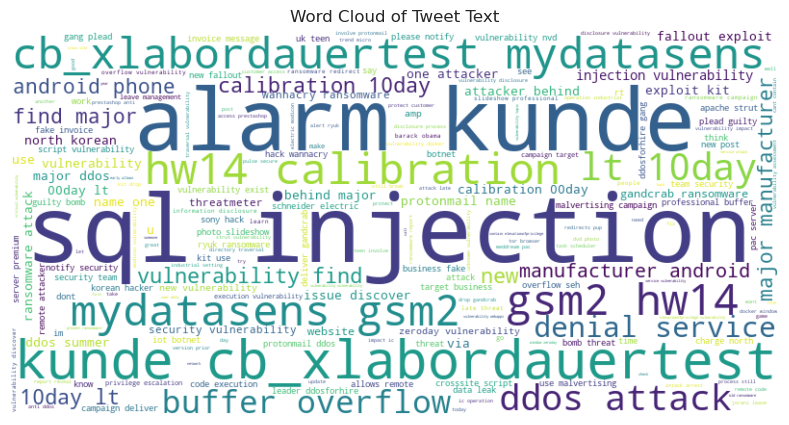

In [19]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    text=" ".join(tweets['clean_text'])
)
plt.figure(figsize=(15, 5))
plt.imshow(X=wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Tweet Text")
plt.show()

#### 4.1.3. Text Length Distribution

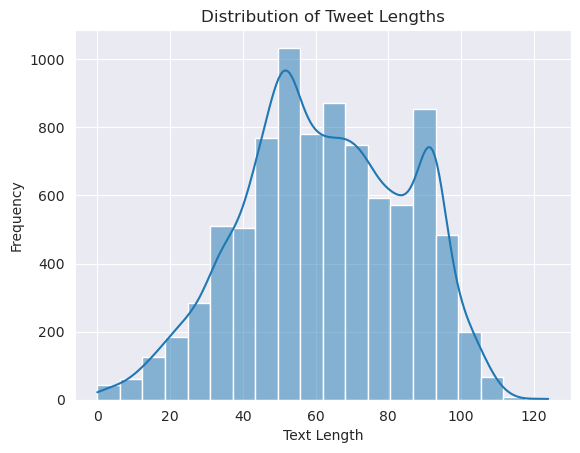

In [20]:
tweets['length_text'] = tweets['clean_text'].apply(func=len)
sns.histplot(data=tweets['length_text'], bins=20, kde=True)
plt.title(label="Distribution of Tweet Lengths")
plt.xlabel(xlabel="Text Length")
plt.ylabel(ylabel="Frequency")
plt.show()

### 4.3. Watson List Analysis
In the `watson_list` attribute, it is performed category depth, co-occurrence patterns, and top-level category distribution analyses.

In [21]:
# Flatten watson_list and count category frequencies
all_categories = [category for sublist in tweets["watson_list"] for category in sublist]
category_freq = Counter(all_categories)
print("Top 10 Most Frequent Categories:", category_freq.most_common(n=10))

Top 10 Most Frequent Categories: [('technology and computing', 7863), ('computer security', 4555), ('antivirus and malware', 3364), ('software', 2878), ('network security', 1643), ('society', 1605), ('hardware', 1603), ('computer', 1295), ('crime', 1265), ('business and industrial', 1246)]


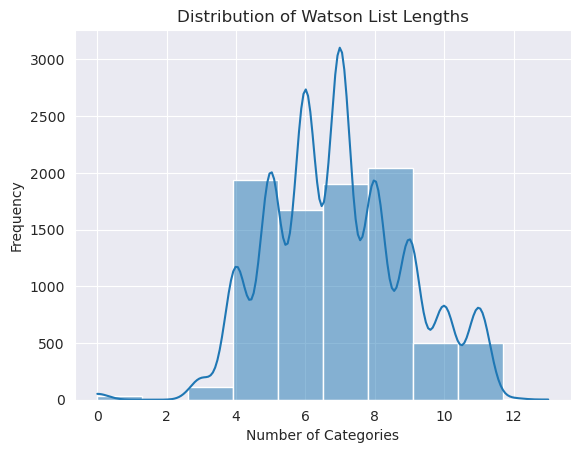

In [22]:
# Category Depth Analysis
tweets["watson_list_length"] = tweets["watson_list"].apply(func=len)
sns.histplot(data=tweets["watson_list_length"], bins=10, kde=True)
plt.title(label="Distribution of Watson List Lengths")
plt.xlabel(xlabel="Number of Categories")
plt.ylabel(ylabel="Frequency")
plt.show()

In [23]:
# Create co-occurrence matrix
co_occurrence = Counter()
for categories in tweets["watson_list"]:
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            co_occurrence[(categories[i], categories[j])] += 1

print("Top 10 Co-occurring Category Pairs:", co_occurrence.most_common(n=10))

Top 10 Co-occurring Category Pairs: [(('technology and computing', 'computer security'), 4555), (('technology and computing', 'antivirus and malware'), 3364), (('computer security', 'antivirus and malware'), 3364), (('technology and computing', 'software'), 2878), (('technology and computing', 'network security'), 1643), (('computer security', 'network security'), 1643), (('technology and computing', 'hardware'), 1603), (('technology and computing', 'computer'), 1295), (('hardware', 'computer'), 1295), (('society', 'crime'), 1265)]


In [24]:
# Top-Level Category Distribution
top_level_categories = [category.split()[0] for category in all_categories]
top_level_freq = Counter(top_level_categories)
print("Top-Level Category Frequencies:", top_level_freq.most_common())

Top-Level Category Frequencies: [('technology', 7863), ('computer', 6594), ('antivirus', 3364), ('software', 2881), ('network', 1707), ('society', 1605), ('hardware', 1603), ('business', 1409), ('crime', 1265), ('databases', 1168), ('consumer', 1118), ('law,', 1028), ('science', 908), ('art', 847), ('home', 787), ('operating', 751), ('programming', 731), ('personal', 721), ('property', 683), ('health', 618), ('hobbies', 454), ('tv', 449), ('javascript', 422), ('government', 414), ('physics', 393), ('optics', 379), ('burglary', 377), ('networking', 377), ('telephones', 369), ('mobile', 364), ('movies', 354), ('linux', 352), ('finance', 343), ('assault', 338), ('smart', 337), ('internet', 333), ('vpn', 328), ('legal', 302), ('sports', 282), ('food', 272), ('law', 255), ('java', 240), ('disease', 239), ('travel', 236), ('company', 232), ('kidnapping', 227), ('windows', 223), ('legislation', 215), ('police', 215), ('disorders', 214), ('music', 192), ('weather', 191), ('games', 190), ('ment

### 4.4. Target Analysis

Target Frequencies:
computer security: 4555
software: 3142
other: 1804
hardware: 1648
operating systems: 751
networking: 685


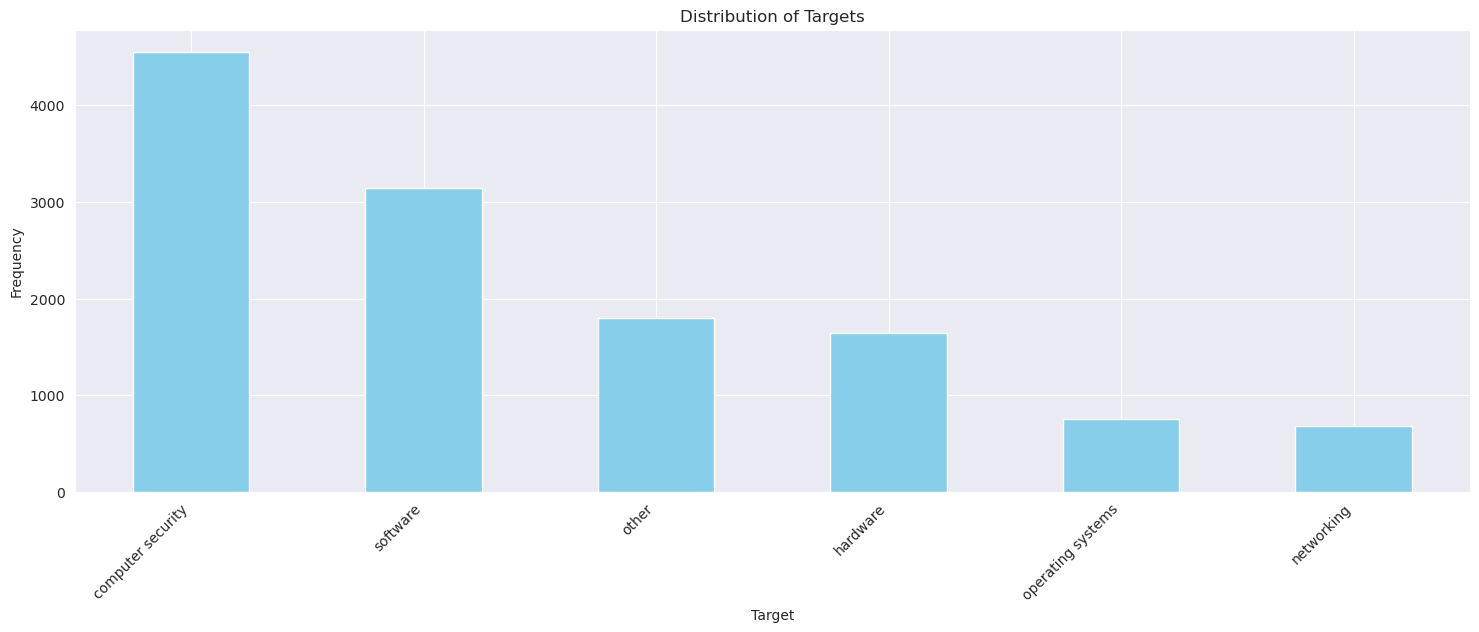

In [25]:
class_freq = Counter([item for sublist in tweets["target"] for item in sublist])

print("Target Frequencies:")
for target, freq in class_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))
pd.Series(data=class_freq).sort_values(ascending=False).plot(
    kind="bar", color="skyblue"
)
plt.title("Distribution of Targets")
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

Target Frequencies:
('computer security',): 2237
('other',): 1804
('software', 'computer security'): 1147
('software',): 642
('hardware',): 481
('computer security', 'hardware'): 419
('software', 'hardware'): 342
('software', 'operating systems'): 310
('software', 'computer security', 'hardware'): 196
('networking',): 166
('software', 'operating systems', 'computer security'): 144
('software', 'networking'): 143
('software', 'computer security', 'networking'): 143
('computer security', 'networking'): 116
('operating systems',): 108
('operating systems', 'computer security'): 88
('software', 'operating systems', 'hardware'): 50
('computer security', 'networking', 'hardware'): 47
('networking', 'hardware'): 45
('operating systems', 'hardware'): 29
('software', 'networking', 'hardware'): 21
('operating systems', 'computer security', 'hardware'): 18
('software', 'operating systems', 'networking'): 4


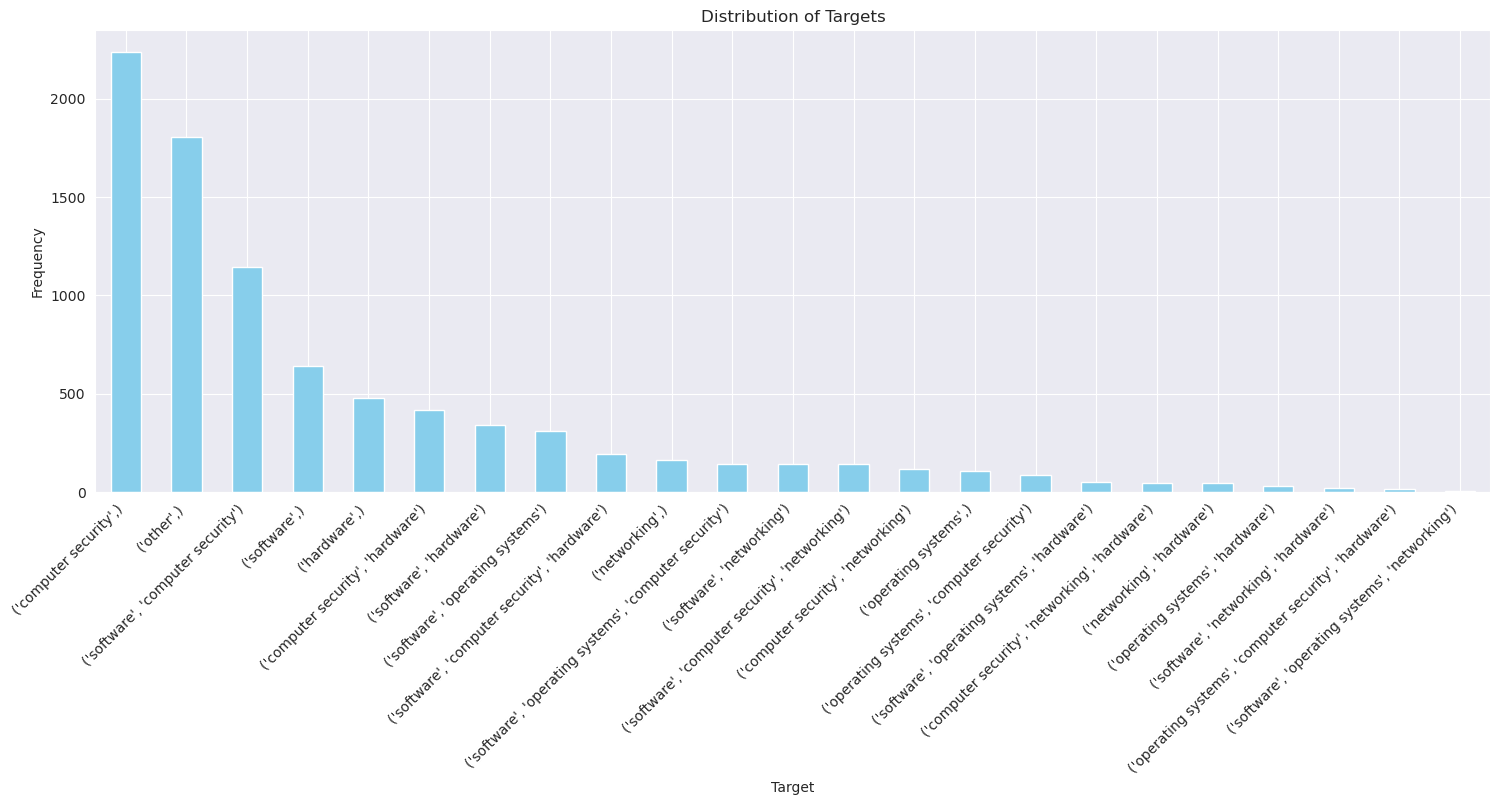

In [26]:
target_freq = Counter(tuple(item) for item in tweets["target"])

print("Target Frequencies:")
for target, freq in target_freq.most_common():
    print(f"{target}: {freq}")

_, ax = plt.subplots(figsize=(18, 6))

(
    pd.Series(data={str(k): v for k, v in target_freq.items()})
    .sort_values(ascending=False)
    .plot(kind="bar", color="skyblue")
)

plt.title("Distribution of Targets")
plt.xlabel("Target")
plt.ylabel("Frequency")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

In [27]:
# Multi-Label Analysis
multi_label_counts = tweets["target"].apply(func=lambda x: len(x) > 1).sum()
print(f"Number of tweets with multiple targets: {multi_label_counts}")

Number of tweets with multiple targets: 3262


In [28]:
# Text-Target Relationship
target_text_pairs = [
    (target, text)
    for targets, text in zip(tweets["target"], tweets['clean_text'])
    for target in targets
]

target_text_df = pd.DataFrame(data=target_text_pairs, columns=["target", "text"])

for target in class_freq:
    target_texts = target_text_df[
        target_text_df["target"].apply(func=lambda x: target in x)
    ]["text"]
    vectorizer = CountVectorizer(stop_words="english")
    word_counts = vectorizer.fit_transform(raw_documents=target_texts)
    word_freq = pd.Series(
        data=word_counts.sum(axis=0).A1, index=vectorizer.get_feature_names_out()
    )
    print(f"Top 10 words for target '{target}':")
    print(word_freq.nlargest(10))

Top 10 words for target 'computer security':
vulnerability    1715
ddos              876
attack            624
ransomware        509
security          428
injection         423
sql               398
exploit           357
new               333
attacker          277
dtype: int64
Top 10 words for target 'software':
vulnerability    1444
injection         475
sql               439
buffer            270
security          269
overflow          265
exploit           225
version           182
remote            163
attack            159
dtype: int64
Top 10 words for target 'hardware':
vulnerability    613
android          243
phone            217
major            206
manufacturer     204
attack           178
ransomware       172
ddos             151
remote           128
hacker           116
dtype: int64
Top 10 words for target 'other':
10day                 605
ransomware            401
lt                    376
alarm                 374
calibration           374
cb_xlabordauertest    374
gsm2 

## 5. Feature Engineering

In [29]:
# Find valid targets (with frequency ≥ 5)
valid_targets = {target for target, freq in target_freq.items() if freq >= 5}

# Filter the DataFrame to keep only valid targets
filtered_df = tweets[tweets["target"].apply(lambda x: tuple(x) in valid_targets)]

# Reset the index (optional)
filtered_df = filtered_df.reset_index(drop=True)

# Print the updated target frequencies
updated_target_freq = Counter(tuple(item) for item in filtered_df["target"])
print("Updated Target Frequencies:")
for target, freq in updated_target_freq.most_common():
    print(f"{target}: {freq}")

Updated Target Frequencies:
('computer security',): 2237
('other',): 1804
('software', 'computer security'): 1147
('software',): 642
('hardware',): 481
('computer security', 'hardware'): 419
('software', 'hardware'): 342
('software', 'operating systems'): 310
('software', 'computer security', 'hardware'): 196
('networking',): 166
('software', 'operating systems', 'computer security'): 144
('software', 'networking'): 143
('software', 'computer security', 'networking'): 143
('computer security', 'networking'): 116
('operating systems',): 108
('operating systems', 'computer security'): 88
('software', 'operating systems', 'hardware'): 50
('computer security', 'networking', 'hardware'): 47
('networking', 'hardware'): 45
('operating systems', 'hardware'): 29
('software', 'networking', 'hardware'): 21
('operating systems', 'computer security', 'hardware'): 18


Preprocess the `text` column into embeddings

In [30]:
def load_word2vec_dict(
        model_path: Path, embedding_dim: int
) -> dict[Union[str, list[str]], np.ndarray[Any, np.dtype]]:
    embeddings_dict = {}
    f = open(model_path, "r", encoding="utf-8")
    for line in f:
        values = line.split()
        word = values[:-embedding_dim]

        if type(word) is list:
            word = " ".join(word)

        vector = asarray([float(val) for val in values[-embedding_dim:]])
        embeddings_dict[word] = vector
    f.close()
    return embeddings_dict


def tokenizer_transform(
        x: pd.Series,
        embedder_addr: str,
        preprocessing_list: Optional[list[Callable[[str], str]]] = None,
) -> np.ndarray[Any, np.dtype[Any]]:
    """
    Generate embeddings for the sentences in the DataFrame.

    Parameters
    ----------
    x : pd.Series
        The DataFrame containing the sentences.
    embedder_addr : str
        Address of the embedder.
    preprocessing_list : Optional[list[Callable[[str], str]]]
        List of functions to apply to each sentence.

    Returns
    -------
    encoded_sentences : ArrayLike

    """
    # Preprocess the text
    sentences = x.tolist()

    if preprocessing_list is None:
        preprocessing_list = []

    for preprocessor in preprocessing_list:
        sentences = [preprocessor(s) for s in sentences]

    model = SentenceTransformer(model_name_or_path=embedder_addr)
    return model.encode(sentences)


def preprocess_texts(list_str, model_path, embedding_dim):
    if embedding_dim is None:
        return tokenizer_transform(x=list_str, embedder_addr=model_path)

    word2vec_dict = load_word2vec_dict(
        model_path=model_path, embedding_dim=embedding_dim
    )
    list_embedded_str = np.zeros((len(list_str), embedding_dim))

    for i, text in enumerate(list_str):
        tokens = re.findall(r"\w+|[{}]".format(re.escape(string.punctuation)), text)
        for token in tokens:
            try:
                list_embedded_str[i] += word2vec_dict[token.lower()]
            except KeyError:
                continue

    return list_embedded_str

In [31]:
texts = filtered_df["text"]
targets = filtered_df["text"]

Convert the `target` column into a binary multi-label matrix

In [32]:
mlb = preprocessing.MultiLabelBinarizer()
y = mlb.fit_transform(y=filtered_df["target"])

Create a dictionary that maps label indices to unique label sets

In [33]:
targets_list_mcp, y_mcp = np.unique(ar=y, axis=0, return_inverse=True)
targets_dict_mcp = {i: tuple(lbl_set) for i, lbl_set in enumerate(targets_list_mcp)}

## 6. Model Training

In [61]:
METHODS = {
    "br": MLC.BRClassifier,
    "clr": MLC.CLRClassifier,
    "cc": MLC.CCClassifier,
    "lp": MLC.LPClassifier,
    "pst": MLC.PStClassifier,
    #'cdn': MLC.CDNClassifier,
    "mbr": MLC.MBRClassifier,
    "rakel": MLC.RAkELClassifier,
    "homer": MLC.HOMERClassifier,
}

CLASSIFIERS = {
    "lr": LogisticRegression(solver="liblinear", max_iter=10000),
    "gnb": GaussianNB(),
    "dt": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "rf": RandomForestClassifier(random_state=RANDOM_STATE),
    #'xgb': XGBClassifier(random_state=RANDOM_STATE)
}

EMBEDDERS = [
    {
        "name": "GloVe.6B.50D",
        "model-path": "../embedders/glove.6B.50d.txt",
        "embedding-dim": 50,
    },
    {
        "name": "GloVe.6B.100D",
        "model-path": "../embedders/glove.6B.100d.txt",
        "embedding-dim": 100,
    },
    {
        "name": "GloVe.6B.200D",
        "model-path": "../embedders/glove.6B.200d.txt",
        "embedding-dim": 200,
    },
    {
        "name": "GloVe.6B.300D",
        "model-path": "../embedders/glove.6B.300d.txt",
        "embedding-dim": 300,
    },
    {
        "name": "DistilRoBERTa",
        "model-path": "sentence-transformers/all-distilroberta-v1",
        "embedding-dim": None,
    },
    {
        "name": "SBERT",
        "model-path": "sentence-transformers/all-mpnet-base-v2",
        "embedding-dim": None,
    },
    {"name": "ATT&CK-BERT", "model-path": "basel/ATTACK-BERT", "embedding-dim": None},
]

In [69]:
for embedder in tqdm(EMBEDDERS, desc="Embedders", unit="embedder"):
    general_models = {}
    x = preprocess_texts(
        list_str=texts,
        model_path=embedder["model-path"],
        embedding_dim=embedder["embedding-dim"],
    )
    X_train, X_val, y_train, y_val = train_test_split(
        x,
        y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        shuffle=True,
        stratify=y_mcp,
    )
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    models_to_embedder = []
    for name_method, name_classifier in product(
            METHODS, CLASSIFIERS, desc="Methods & Classifiers", unit="pair"
    ):
        model = METHODS[name_method](CLASSIFIERS[name_classifier])
        try:
            model.fit(X_train, y_train)
            name_model = (
                f"{name_method.upper()}[{name_classifier.upper()}] - {embedder['name']}"
            )
        except Exception as e:
            print(f"{model} failed to fit due to {e}")
            name_model = None
            continue
        if name_model is not None:
            models_to_embedder.append(name_model)
            general_models[name_model] = {
                "model": model,
                "assess": model.evaluate(X_val, y_val),
            }
    best_model = {}
    for name_model in models_to_embedder:
        temp_performance = general_models[name_model]["assess"]["report"][
            "weighted avg"
        ]["f1-score"]
        if len(best_model) == 0:
            best_model["name"] = name_model
            best_model["performance"] = temp_performance
        else:
            if best_model["performance"] < temp_performance:
                best_model["name"] = name_model
                best_model["performance"] = temp_performance
    print("==========================================================")
    print(f"{best_model['name']} - Accuracy:\t{general_models[best_model['name']]['assess']['accuracy'] * 100:.2f}%")
    print("==========================================================")
    report = pd.DataFrame(general_models[best_model["name"]]["assess"]["report"])
    report.columns = list(mlb.classes_) + ["micro avg", "macro avg", "weighted avg", "samples avg"]
    report = (report.transpose().map(lambda x: f"{x:.2f}" if isinstance(x, float) else x).to_string())
    print(f"{report}")
    with open(f"../models/general/{best_model['name']}.pkl", "wb") as f:
        pickle.dump(general_models[best_model["name"]], f)
    with open(f"../models/dictionaries/{embedder['name']}.pkl", "wb") as f:
        pickle.dump(general_models, f)
    print("==========================================================")
    del x, X_train, X_val, y_train, y_val, scaler, models_to_embedder, best_model, report

Embedders:   0%|          | 0/7 [00:00<?, ?embedder/s]

Methods & Classifiers:   0%|          | 0/32 [00:00<?, ?pair/s]

HOMERClassifier(base_estimator=LogisticRegression(max_iter=10000,
                                                  solver='liblinear')) failed to fit due to This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(1)
LP[RF] - GloVe.6B.50D - Accuracy:	66.72%
                  precision recall f1-score  support   auc
computer security      0.77   0.91     0.83   912.00  0.80
hardware               0.89   0.53     0.67   329.00  0.76
networking             0.94   0.57     0.71   136.00  0.78
operating systems      1.00   0.62     0.77   151.00  0.81
other                  0.66   0.66     0.66   361.00  0.79
software               0.90   0.78     0.84   627.00  0.87
micro avg              0.81   0.76     0.78  2516.00  0.85
macro avg              0.86   0.68     0.75  2516.00  0.80
weighted avg           0.83   0.76     0.78  2516.00  0.81
samples avg            0.78   0.75     0.76  2516.00  0.85


Methods & Classifiers:   0%|          | 0/32 [00:00<?, ?pair/s]

HOMERClassifier(base_estimator=LogisticRegression(max_iter=10000,
                                                  solver='liblinear')) failed to fit due to This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(1)
LP[RF] - GloVe.6B.100D - Accuracy:	66.44%
                  precision recall f1-score  support   auc
computer security      0.76   0.93     0.84   912.00  0.80
hardware               0.91   0.51     0.65   329.00  0.75
networking             0.95   0.56     0.70   136.00  0.78
operating systems      0.99   0.60     0.75   151.00  0.80
other                  0.71   0.63     0.67   361.00  0.78
software               0.88   0.76     0.82   627.00  0.85
micro avg              0.81   0.75     0.78  2516.00  0.85
macro avg              0.87   0.67     0.74  2516.00  0.79
weighted avg           0.83   0.75     0.77  2516.00  0.80
samples avg            0.78   0.75     0.75  2516.00  0.85


Methods & Classifiers:   0%|          | 0/32 [00:00<?, ?pair/s]

HOMERClassifier(base_estimator=LogisticRegression(max_iter=10000,
                                                  solver='liblinear')) failed to fit due to This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(1)
LP[RF] - GloVe.6B.200D - Accuracy:	66.84%
                  precision recall f1-score  support   auc
computer security      0.77   0.91     0.83   912.00  0.80
hardware               0.91   0.52     0.66   329.00  0.75
networking             0.95   0.55     0.70   136.00  0.77
operating systems      0.96   0.61     0.74   151.00  0.80
other                  0.68   0.69     0.69   361.00  0.80
software               0.91   0.76     0.83   627.00  0.86
micro avg              0.81   0.75     0.78  2516.00  0.85
macro avg              0.86   0.67     0.74  2516.00  0.80
weighted avg           0.83   0.75     0.78  2516.00  0.81
samples avg            0.78   0.75     0.76  2516.00  0.85


Methods & Classifiers:   0%|          | 0/32 [00:00<?, ?pair/s]

HOMERClassifier(base_estimator=LogisticRegression(max_iter=10000,
                                                  solver='liblinear')) failed to fit due to This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(1)
LP[RF] - GloVe.6B.300D - Accuracy:	67.87%
                  precision recall f1-score  support   auc
computer security      0.77   0.93     0.84   912.00  0.81
hardware               0.93   0.53     0.67   329.00  0.76
networking             0.94   0.58     0.72   136.00  0.79
operating systems      0.99   0.64     0.78   151.00  0.82
other                  0.73   0.68     0.70   361.00  0.81
software               0.92   0.75     0.83   627.00  0.86
micro avg              0.82   0.76     0.79  2516.00  0.85
macro avg              0.88   0.69     0.76  2516.00  0.81
weighted avg           0.84   0.76     0.78  2516.00  0.81
samples avg            0.79   0.76     0.77  2516.00  0.85


Methods & Classifiers:   0%|          | 0/32 [00:00<?, ?pair/s]

HOMERClassifier(base_estimator=LogisticRegression(max_iter=10000,
                                                  solver='liblinear')) failed to fit due to This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(1)
LP[RF] - DistilRoBERTa - Accuracy:	67.24%
                  precision recall f1-score  support   auc
computer security      0.78   0.91     0.84   912.00  0.81
hardware               0.94   0.50     0.66   329.00  0.75
networking             0.96   0.54     0.69   136.00  0.77
operating systems      0.96   0.62     0.76   151.00  0.81
other                  0.67   0.73     0.70   361.00  0.82
software               0.93   0.73     0.82   627.00  0.85
micro avg              0.82   0.75     0.78  2516.00  0.85
macro avg              0.87   0.67     0.74  2516.00  0.80
weighted avg           0.84   0.75     0.78  2516.00  0.81
samples avg            0.79   0.75     0.76  2516.00  0.85


Methods & Classifiers:   0%|          | 0/32 [00:00<?, ?pair/s]

HOMERClassifier(base_estimator=LogisticRegression(max_iter=10000,
                                                  solver='liblinear')) failed to fit due to This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(1)
MBR[RF] - SBERT - Accuracy:	62.24%
                  precision recall f1-score  support   auc
computer security      0.86   0.87     0.87   912.00  0.86
hardware               0.93   0.52     0.67   329.00  0.76
networking             0.97   0.57     0.72   136.00  0.79
operating systems      0.97   0.64     0.77   151.00  0.82
other                  0.93   0.52     0.67   361.00  0.76
software               0.89   0.80     0.84   627.00  0.87
micro avg              0.89   0.73     0.80  2516.00  0.85
macro avg              0.93   0.66     0.76  2516.00  0.81
weighted avg           0.90   0.73     0.79  2516.00  0.83
samples avg            0.75   0.71     0.72  2516.00  0.84


Methods & Classifiers:   0%|          | 0/32 [00:00<?, ?pair/s]

HOMERClassifier(base_estimator=LogisticRegression(max_iter=10000,
                                                  solver='liblinear')) failed to fit due to This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(1)
RAKEL[RF] - ATT&CK-BERT - Accuracy:	65.98%
                  precision recall f1-score  support   auc
computer security      0.82   0.91     0.86   912.00  0.85
hardware               0.95   0.52     0.67   329.00  0.76
networking             0.97   0.54     0.70   136.00  0.77
operating systems      0.98   0.61     0.75   151.00  0.80
other                  0.87   0.61     0.72   361.00  0.79
software               0.90   0.78     0.83   627.00  0.86
micro avg              0.87   0.75     0.80  2516.00  0.86
macro avg              0.92   0.66     0.76  2516.00  0.81
weighted avg           0.88   0.75     0.80  2516.00  0.83
samples avg            0.78   0.74     0.75  2516.00  0.85


In [74]:
with open("../models/dictionaries/ATT&CK-BERT.pkl", "rb") as f:
    general_models = pickle.load(f)
for name_model in general_models:
    print("==========================================================")
    print(name_model)
    print(f"Accuracy:\t{general_models[name_model]['assess']['accuracy'] * 100:.2f}%")
    print(f"Hamming Loss:\t{general_models[name_model]['assess']['hamming_loss']:.3f}")
    report = pd.DataFrame(general_models[name_model]["assess"]["report"])
    report.columns = list(mlb.classes_) + ["micro avg", "macro avg", "weighted avg", "samples avg"]
    report = (report.transpose().map(lambda x: f"{x:.2f}" if isinstance(x, float) else x).to_string())
    print(f"{report}")
    print("==========================================================")
del general_models

BR[LR] - ATT&CK-BERT
Accuracy:	54.54%
Hamming Loss:	0.119
                  precision recall f1-score  support   auc
computer security      0.80   0.84     0.82   912.00  0.80
hardware               0.68   0.57     0.62   329.00  0.75
networking             0.67   0.62     0.64   136.00  0.80
operating systems      0.71   0.71     0.71   151.00  0.84
other                  0.71   0.64     0.67   361.00  0.79
software               0.79   0.79     0.79   627.00  0.83
micro avg              0.76   0.74     0.75  2516.00  0.83
macro avg              0.73   0.69     0.71  2516.00  0.80
weighted avg           0.76   0.74     0.75  2516.00  0.80
samples avg            0.72   0.73     0.71  2516.00  0.83
BR[GNB] - ATT&CK-BERT
Accuracy:	26.03%
Hamming Loss:	0.231
                  precision recall f1-score  support   auc
computer security      0.71   0.68     0.70   912.00  0.69
hardware               0.38   0.45     0.41   329.00  0.64
networking             0.20   0.74     0.31   136.00  0.7

# 7. Model Evaluation

In [90]:
with open("../data/tweets-dataset/categories_test.csv", "rb") as f:
    test_tweets = pd.read_csv(f)

test_tweets = test_tweets.assign(
    tweet=lambda df: df["tweet"].apply(func=ast.literal_eval),
    watson=lambda df: df["watson"].apply(func=ast.literal_eval),
    urls=lambda df: df["urls"].apply(func=ast.literal_eval),
    watson_list=lambda df: df["watson_list"].apply(func=ast.literal_eval),
    target=lambda df: df["target"].apply(func=ast.literal_eval),
)

test_tweets = test_tweets.assign(
    target=lambda df: df["target"].apply(func=map_targets, args=(FIX_TARGETS,))
)
test_tweets['text'] = [replace_text_components(t) for t in test_tweets['text']]

print(f"Threat Tweets: {len(test_tweets)}")
test_tweets.head()

Threat Tweets: 2176


,Unnamed: 0,_id,date,id,relevant,text,tweet,type,watson,annotation,urls,destination_url,valid_certificate,watson_list,target
0,7083,b'5b93abb3bb325e521c5aee04',2018-09-08 11:00:03+00:00,1038381444463304705,True,Protect your customers access Prestashop Anti DDoS Attack,"{'created_at': 'Sat Sep 08 11:00:03 +0000 2018', 'id': 1038381444463304705, 'id_str': '1038381444463304705', 'text': 'Protect your customers access Prestashop Anti DDoS Attack #Prestashop https://t.co/xUGxiI8zw8 https://t.co/w4potu8ABT', 'display_text_range': [0, 96], 'source': '<a href=""https://dapicart.com/"" rel=""nofollow"">dapi</a>', 'truncated': False, 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 2842644562, 'id_str': '2842644562', 'name': 'Best Prestashop Temp', 'screen_name': 'prestashop_free', 'location': None, 'url': 'http://mcaf.ee/n2w9z3?prestashop_free', 'description': None, 'translator_type': 'none', 'protected': False, 'verified': False, 'followers_count': 3856, 'friends_count': 4970, 'listed_count': 60, 'favourites_count': 69072, 'statuses_count': 137955, 'created_at': 'Fri Oct 24 14:57:29 +0000 2014', 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'lang': 'pt', 'contributors_enabled': False, 'is_translator': False, 'profile_background_color': 'C0DEED', 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_tile': False, 'profile_link_color': '1DA1F2', 'profile_sidebar_border_color': 'C0DEED', 'profile_sidebar_fill_color': 'DDEEF6', 'profile_text_color': '333333', 'profile_use_background_image': True, 'profile_image_url': 'http://pbs.twimg.com/profile_images/798302454970458112/03B6dkIX_normal.jpg', 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/798302454970458112/03B6dkIX_normal.jpg', 'profile_banner_url': 'https://pbs.twimg.com/profile_banners/2842644562/1479165249', 'default_profile': True, 'default_profile_image': False, 'following': None, 'follow_request_sent': None, 'notifications': None}, 'geo': None, 'coordinates': None, 'place': None, 'contributors': None, 'is_quote_status': False, 'quote_count': 0, 'reply_count': 0, 'retweet_count': 0, 'favorite_count': 0, 'entities': {'hashtags': [{'text': 'Prestashop', 'indices': [60, 71]}], 'urls': [{'url': 'https://t.co/xUGxiI8zw8', 'expanded_url': 'http://addons.prestashop.com/en/23513-anti-ddos-attack.html', 'display_url': 'addons.prestashop.com/en/23513-anti-…', 'indices': [73, 96]}], 'user_mentions': [], 'symbols': [], 'media': [{'id': 1038381443041378304, 'id_str': '1038381443041378304', 'indices': [97, 120], 'media_url': 'http://pbs.twimg.com/media/DmkSa73WwAAZ96p.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DmkSa73WwAAZ96p.jpg', 'url': 'https://t.co/w4potu8ABT', 'display_url': 'pic.twitter.com/w4potu8ABT', 'expanded_url': 'https://twitter.com/prestashop_free/status/1038381444463304705/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 1000, 'h': 1000, 'resize': 'fit'}, 'small': {'w': 680, 'h': 680, 'resize': 'fit'}, 'large': {'w': 1000, 'h': 1000, 'resize': 'fit'}}}]}, 'extended_entities': {'media': [{'id': 1038381443041378304, 'id_str': '1038381443041378304', 'indices': [97, 120], 'media_url': 'http://pbs.twimg.com/media/DmkSa73WwAAZ96p.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DmkSa73WwAAZ96p.jpg', 'url': 'https://t.co/w4potu8ABT', 'display_url': 'pic.twitter.com/w4potu8ABT', 'expanded_url': 'https://twitter.com/prestashop_free/status/1038381444463304705/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 1000, 'h': 1000, 'resize': 'fit'}, 'small': {'w': 680, 'h': 680, 'resize': 'fit'}, 'large': {'w': 1000, 'h': 1000, 'resize': 'fit'}}}]}, 'favorited': False, 'retweeted': F

In [92]:
X_test = preprocess_texts(
    list_str=test_tweets['text'],
    model_path="basel/ATTACK-BERT",
    embedding_dim=None,
)
X_test = preprocessing.StandardScaler().fit_transform(X_test)
y_test = mlb.transform(y=test_tweets["target"])

In [156]:
with open("../models/dictionaries/ATT&CK-BERT.pkl", "rb") as f:
    general_models = pickle.load(f)

attack_models = {}
for idx in range(6):
    best_model = {}
    for name_model in general_models:
        temp_performance = general_models[name_model]["assess"]["report"][f"{idx}"]["f1-score"]
        #temp_performance = general_models[name_model]["assess"]["accuracy"]
        if len(best_model) == 0:
            best_model["name"] = name_model
            best_model["performance"] = temp_performance
            best_model["model"] = general_models[name_model]["model"]
        else:
            if best_model["performance"] < temp_performance:
                best_model["name"] = name_model
                best_model["performance"] = temp_performance
                best_model["model"] = general_models[name_model]["model"]
    print("==========================================================")
    print(f"{mlb.classes_[idx]}: {best_model['name']}")
    print("==========================================================")
    print(f"Accuracy:\t{general_models[best_model["name"]]['assess']['accuracy'] * 100:.2f}%")
    print(f"Hamming Loss:\t{general_models[best_model["name"]]['assess']['hamming_loss']:.3f}")
    report = pd.DataFrame(general_models[best_model["name"]]["assess"]["report"])
    report.columns = list(mlb.classes_) + ["micro avg", "macro avg", "weighted avg", "samples avg"]
    report = (report.transpose().map(lambda x: f"{x:.2f}" if isinstance(x, float) else x).to_string())
    print(f"{report}")
    print("==========================================================\n")
    attack_models[f"{idx}"] = best_model
del general_models

computer security: RAKEL[RF] - ATT&CK-BERT
Accuracy:	65.98%
Hamming Loss:	0.088
                  precision recall f1-score  support   auc
computer security      0.82   0.91     0.86   912.00  0.85
hardware               0.95   0.52     0.67   329.00  0.76
networking             0.97   0.54     0.70   136.00  0.77
operating systems      0.98   0.61     0.75   151.00  0.80
other                  0.87   0.61     0.72   361.00  0.79
software               0.90   0.78     0.83   627.00  0.86
micro avg              0.87   0.75     0.80  2516.00  0.86
macro avg              0.92   0.66     0.76  2516.00  0.81
weighted avg           0.88   0.75     0.80  2516.00  0.83
samples avg            0.78   0.74     0.75  2516.00  0.85

hardware: MBR[RF] - ATT&CK-BERT
Accuracy:	62.59%
Hamming Loss:	0.089
                  precision recall f1-score  support   auc
computer security      0.85   0.86     0.85   912.00  0.85
hardware               0.94   0.55     0.69   329.00  0.77
networking             0

In [153]:
general = ModuleSystem(attack_models, mlb.classes_)
y_pred = general.predict(X_test)

# Convert the predicted labels back to the original format using MultiLabelBinarizer
#y_pred_labels = mlb.inverse_transform(y_pred)
assessment = assess(y_test, y_pred)
print("==========================================================")
print("System Performance")
print("==========================================================")
print(f"Accuracy:\t{assessment['accuracy'] * 100:.2f}%")
print(f"Hamming Loss:\t{assessment['hamming_loss']:.3f}")
report = pd.DataFrame(assessment["report"])
report.columns = list(mlb.classes_) + ["micro avg", "macro avg", "weighted avg", "samples avg"]
report = (report.transpose().map(lambda x: f"{x:.2f}" if isinstance(x, float) else x).to_string())
print(f"{report}")
print("==========================================================\n")

System Performance
Accuracy:	65.26%
Hamming Loss:	0.089
                  precision recall f1-score  support   auc
computer security      0.83   0.90     0.86  1141.00  0.85
hardware               0.94   0.56     0.70   411.00  0.78
networking             0.72   0.60     0.66   173.00  0.79
operating systems      0.93   0.66     0.77   183.00  0.83
other                  0.87   0.61     0.71   451.00  0.79
software               0.90   0.77     0.83   783.00  0.86
micro avg              0.86   0.75     0.80  3142.00  0.86
macro avg              0.87   0.68     0.76  3142.00  0.82
weighted avg           0.87   0.75     0.80  3142.00  0.83
samples avg            0.78   0.75     0.75  3142.00  0.85



In [154]:
with open("../models/GENERAL.pkl", "wb") as f:
    pickle.dump(general, f)